In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
from datetime import datetime
import re
import tensorflow as tf
from read_data import read_data

In [ ]:
def create_legend(lrs, clrs):
    legend_elements = []
    for c, lr in zip(clrs,lrs):
        legend_elements.append(Line2D([0], [0], color=c, lw=4, label='lr=' + lr))

    legend_elements.append(Line2D([0], [0], dashes=(2,1), lw=4, color='k', label='training'))
    legend_elements.append(Line2D([0], [0], lw=4, color='k', label='validation'))

    return legend_elements

In [ ]:
def plot_tr_vs_val(lrs, hists, clrs, tr_key, val_key, title, splot, shared_ax, bottom, save):
    end = 100
    max_loss = 2

    if shared_ax is None:
        rv = plt.subplot(splot[0],splot[1],splot[2])
        plt.ylabel(tr_key)
    else:
        rv = plt.subplot(splot[0],splot[1],splot[2], sharey=shared_ax)
        plt.setp(rv.get_yticklabels(), visible=False)
        plt.subplots_adjust(wspace = .05)

    max_val = 0
    best_val_lr = 0
    max_tr = 0
    best_tr_lr = 0

    for c, lr, hist in zip(clrs,lrs,hists):

        if max_val < np.max(hist[val_key]):
            max_val = np.max(hist[val_key])
            best_val_lr = lr

        if max_tr < np.max(hist[tr_key]):
            max_tr = np.max(hist[tr_key])
            best_tr_lr = lr

        plt.plot(hist[tr_key][0:end], c +'--')
        plt.plot(hist[val_key][0:end], c+ '-')

    print("max for " + str(tr_key) + " " + str(max_tr) + " with lr=" + str(best_tr_lr))
    print("max for " + str(val_key) + " " + str(max_val) + " with lr=" + str(best_val_lr))
    plt.title(title)
    if (bottom):
        plt.xlabel('Epochs')
    else:
        plt.subplots_adjust(hspace = .2)
    
    if (tr_key.find('accuracy') != -1):
        ax = plt.gca()
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    else:
        plt.ylim([0,max_loss])

    return rv

In [ ]:
def plot_training_multiple(file, title, save):

    run_folder = './saved_runs/'
    files = os.listdir(run_folder)

    age_hists = []
    gender_hists = []
    race_hists = []
    age_lrs = []
    gender_lrs = []
    race_lrs = []
    lrre = re.compile('lr_\d+.\d+')

    found_age = False
    found_gender = False
    found_race = False
    
    
    for f in files:
        idx = f.find(file)
        if idx != -1:
            # lrs.append(lrre.search(f).group()[3:])
            hist = pd.read_csv(run_folder + f, index_col=0)
            hist = hist.to_dict('split')
            hist = dict(zip(hist['index'],hist['data']))
            age_idx = f.find(file + '_age')
            gender_idx = f.find(file + '_gender')
            race_idx = f.find(file + '_race')
            if age_idx != -1:
                found_age = True
                age_lrs.append(lrre.search(f).group()[3:])
                age_hists.append(hist)
            elif gender_idx != -1:
                found_gender = True
                gender_lrs.append(lrre.search(f).group()[3:])
                gender_hists.append(hist)
            elif race_idx != -1:
                found_race = True
                race_lrs.append(lrre.search(f).group()[3:])
                race_hists.append(hist)

    fig = plt.figure(figsize=(10,10))
    fig.suptitle(title)
    age_clrs = 'bgrcmykw'[0:len(age_lrs)]
    gender_clrs = 'bgrcmykw'[0:len(gender_lrs)]
    race_clrs = 'bgrcmykw'[0:len(race_lrs)]


    age_lrs, age_hists = zip(*sorted(zip(age_lrs,age_hists)))
    gender_lrs, gender_hists = zip(*sorted(zip(gender_lrs,gender_hists)))
    race_lrs, race_hists = zip(*sorted(zip(race_lrs,race_hists)))


    n_h_plots = found_age + found_gender + found_race
    cur_plot = 1
    # acc_ax = plt.subplot(231)
    # loss_ax = plt.subplot(234)
    if (found_age):
        print('plotting age')
        acc_ax = plot_tr_vs_val(age_lrs, age_hists, age_clrs, 'accuracy', 'val_accuracy',  'Age Accuracy', (2,n_h_plots,cur_plot), None, False, save)
        loss_ax = plot_tr_vs_val(age_lrs, age_hists, age_clrs, 'loss', 'val_loss', 'Age Loss', (2,n_h_plots,cur_plot + n_h_plots), None, True, save)
        cur_plot += 1

    if (found_gender):
        print('plotting gender')
        lg_ax = plot_tr_vs_val(gender_lrs, gender_hists, gender_clrs, 'accuracy', 'val_accuracy', 'Gender Accuracy', (2,n_h_plots,cur_plot), acc_ax, False, save)
        plot_tr_vs_val(gender_lrs, gender_hists, gender_clrs, 'loss', 'val_loss', 'Gender Loss', (2,n_h_plots,cur_plot + n_h_plots), loss_ax, True, save)
        cur_plot += 1

    if (found_race):
        print('plotting race')
        plot_tr_vs_val(race_lrs, race_hists, race_clrs, 'accuracy', 'val_accuracy', 'Race Accuracy', (2,n_h_plots,cur_plot), acc_ax, False, save)
        plot_tr_vs_val(race_lrs, race_hists, race_clrs, 'loss', 'val_loss', 'Race Loss', (2,n_h_plots,cur_plot + n_h_plots), loss_ax, True, save)
        cur_plot += 1
        
    # ax = plt.gca()
    lg_ax.legend(handles=create_legend(race_lrs, gender_clrs),bbox_to_anchor=(-1., 1.02, 3., .5), loc='lower left',mode="expand",ncol=5,borderaxespad=2)

    
    if (save):
        plt.savefig('./saved_plots/archive/' + title + ' ' + str(datetime.now().strftime("%m-%d-%Y %H:%M:%S")) + '.png')
        plt.savefig('./saved_plots/' + title + '.png')

    plt.show()

In [ ]:
def plot_training_single(file, title):

    hist = pd.read_csv(file, index_col=0)
    hist = hist.to_dict('split')
    hist = dict(zip(hist['index'],hist['data']))

    plt.plot(hist['accuracy'],label='training')
    plt.plot(hist['val_accuracy'], label='validation')
    plt.legend()
    plt.title(title + ' Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.savefig('./saved_plots/' + title + '_Accuracy_' + str(datetime.now()) + '.png')
    plt.show()

    plt.plot(hist['loss'],label='training')
    plt.plot(hist['val_loss'], label='validation')
    plt.legend()
    plt.title(title + ' Loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.savefig('./saved_plots/' + title + '_Loss_' + str(datetime.now()) + '.png')
    plt.show()

In [ ]:
plot_training_multiple('Task_1', 'Task 1', save=False)

In [ ]:
plot_training_multiple('task_2', 'Task 2', save=True)

In [ ]:
plot_training_multiple('task_3', 'Task 3', save=False)

In [ ]:
def plot_training_4(file, title, save):
    run_folder = './saved_runs/'
    files = os.listdir(run_folder)

    age_hists = []
    gender_hists = []
    race_hists = []
    lrs = []
    lrre = re.compile('lr_\d+.\d+')

    for f in files:
        idx = f.find(file)
        if idx != -1:
            # lrs.append(lrre.search(f).group()[3:])
            hist = pd.read_csv(run_folder + f, index_col=0)
            hist = hist.to_dict('split')
            hist = dict(zip(hist['index'],hist['data']))
            lrs.append(lrre.search(f).group()[3:])
            age_hists.append(hist)
            race_hists.append(hist)

    fig = plt.figure(figsize=(10,10))
    fig.suptitle(title)
    clrs = 'bgrcmykw'[0:len(lrs)]

    _, race_hists = zip(*sorted(zip(lrs,race_hists)))
    lrs, age_hists = zip(*sorted(zip(lrs,age_hists)))


    n_h_plots = 2
    cur_plot = 1
    # acc_ax = plt.subplot(231)
    # loss_ax = plt.subplot(234)
    print('plotting age')
    lg_ax = acc_ax = plot_tr_vs_val(lrs, age_hists, clrs, 'age_accuracy', 'val_age_accuracy',  'Age Accuracy', (2,n_h_plots,cur_plot), None, False, save)
    loss_ax = plot_tr_vs_val(lrs, age_hists, clrs, 'age_loss', 'val_age_loss', 'Age Loss', (2,n_h_plots,cur_plot + n_h_plots), None, True, save)
    cur_plot += 1

    print('plotting race')
    plot_tr_vs_val(lrs, race_hists, clrs, 'race_accuracy', 'val_race_accuracy', 'Race Accuracy', (2,n_h_plots,cur_plot), acc_ax, False, save)
    plot_tr_vs_val(lrs, race_hists, clrs, 'race_loss', 'val_race_loss', 'Race Loss', (2,n_h_plots,cur_plot + n_h_plots), loss_ax, True, save)
    cur_plot += 1
        
    # ax = plt.gca()
    lg_ax.legend(handles=create_legend(lrs, clrs),bbox_to_anchor=(0., 1.02, 2., .5), loc='lower left',mode="expand",ncol=5,borderaxespad=2)

    
    if (save):
        plt.savefig('./saved_plots/archive/' + title + ' ' + str(datetime.now().strftime("%m-%d-%Y %H:%M:%S")) + '.png')
        plt.savefig('./saved_plots/' + title + '.png')

    plt.show()


In [ ]:
plot_training_4('task_4', 'Task 4', save = False)

In [2]:
d = read_data()

In [3]:
def get_conf(d, file):
    with open(file, 'rb') as f:
        predictions = np.load(f)

    return tf.math.confusion_matrix(d['age_v_labels'].argmax(axis=1), predictions.argmax(axis=1), num_classes=len(d['age_classes'])).numpy()

In [30]:
def plot_confs(d, file, name, class_types):
    fig = plt.figure(figsize=(5,2))
    fig.suptitle(name + " Confusion Matrix")
    # fig.tight_layout()
    for i, c in enumerate(class_types):
        conf = get_conf(d, file + f'_{c}preditions')
        ax = plt.subplot(1,3,i+1)
        plt.imshow(conf)
        plt.title(c)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    plt.savefig(name + " Confusion Matrix")
    plt.show()


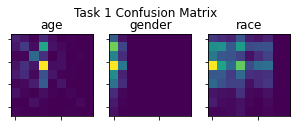

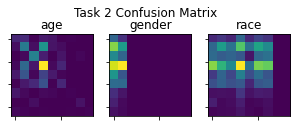

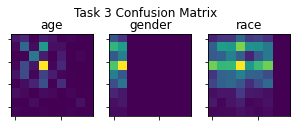

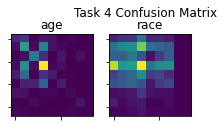

In [31]:

class_types = ['age', 'gender', 'race']
t1 = plot_confs(d, './predictions/Task_1', 'Task 1', class_types)
t2 = plot_confs(d, './predictions/task_2', 'Task 2', class_types)
t3 = plot_confs(d, './predictions/task_3', 'Task 3', class_types)
t3 = plot_confs(d, './predictions/task_4', 'Task 4', [class_types[0], class_types[2]])

In [ ]:

# vae_model = tf.keras.models.load_model('vae_model')
decoder_model = tf.keras.models.load_model('decoder_model')
decoder_model.summary()


In [ ]:
np.random.rand(9).shape

In [ ]:
pred = decoder_model.predict(np.random.rand(1,9))

In [ ]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

